In [1]:
import numpy as np

import pytorch_lightning as pl
from pytorch_lightning.callbacks import TQDMProgressBar

import torch
from torch.utils.data import TensorDataset, DataLoader
from src.model_specpred import SpectrumPredictor
from src.utils_model import lorentzian, spec_to_Sqt, batch_spec_to_Sqt
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

c:\Users\zhantao\.conda\envs\quspin\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = torch.load("data/CrI3/20221110.pt")
X = data['param'][:,:2]
Y = torch.cat((data['omega'], data['inten']), dim=1)

In [3]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=1/5, random_state=42)

train_dataset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [4]:
model_spec = SpectrumPredictor.load_from_checkpoint("training_logs/lightning_logs/version_38/checkpoints/epoch=615-step=15400.ckpt")

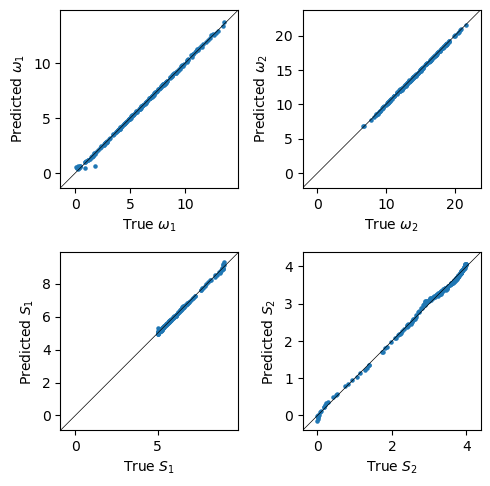

In [5]:
Y_val_pred = []
with torch.no_grad():
    for x_val in X_val:
        Y_val_pred.append(model_spec(x_val).detach())
Y_val_pred = torch.vstack(Y_val_pred)

labels = ['$\omega_1$', '$\omega_2$', '$S_1$', '$S_2$']

fig = plt.figure(figsize=(5,5))
gs = plt.GridSpec(2,2)
for i in range(4):
    ax = fig.add_subplot(gs[i])
    ax.plot([-100,100], [-100,100], 'k', linewidth=0.5)
    ax.scatter(Y_val[:,i], Y_val_pred[:,i], s=5)
    ax.set_aspect('equal')
    ax.set_xlim([-0.1*Y_val[:,i].max(), 1.1*Y_val[:,i].max()])
    ax.set_ylim([-0.1*Y_val[:,i].max(), 1.1*Y_val[:,i].max()])
    ax.set_xlabel(f"True {labels[i]}")
    ax.set_ylabel(f"Predicted {labels[i]}")

fig.tight_layout()

In [6]:
idx = np.random.choice(len(X_val))
# idx = 160
x_val = X_val[idx]
y_val = Y_val[idx]

omega_val, inten_val = [], []
for i in range(2):
    _omega, _inten = lorentzian(y_val[i], 0.5, y_val[i+2], minimum=0.)
    omega_val.append(_omega); inten_val.append(_inten)
omega_val = torch.cat(omega_val); inten_val = torch.cat(inten_val)

time_val = torch.arange(0,10,0.01)
S_val = batch_spec_to_Sqt(omega_val, inten_val, time_val).sum(dim=1).squeeze()
print(x_val, y_val)
print(model_spec(x_val))

tensor([-2.7588, -0.4105]) tensor([10.2492, 16.8845,  5.7185,  3.2815])
tensor([10.2630, 16.8861,  5.7560,  3.2678], grad_fn=<SqueezeBackward3>)


In [8]:
loss_hist = model_spec.fit_measurement(time_val, S_val, lr=0.025, maxiter=2000,
    retrain_criteria=None, J_bounds=(-2.5,0), D_bounds=(-1.0,0), K_bounds=(-1.0,0), 
    supp_data_folder='data/CrI3/20221109_supp', global_dataset=train_dataset, save_param_hist=True, replace_worst_with_mean=True)

# loss_hist = model_spec.fit_measurement(time_val, S_val, lr=0.05, maxiter=10000,
#     retrain_criteria=None, J_bounds=(-2.5,0), D_bounds=(-1.0,0), K_bounds=(-1.0,0))

Iter 1999 Loss 3.063750: 100%|██████████| 2000/2000 [00:07<00:00, 258.59it/s] 


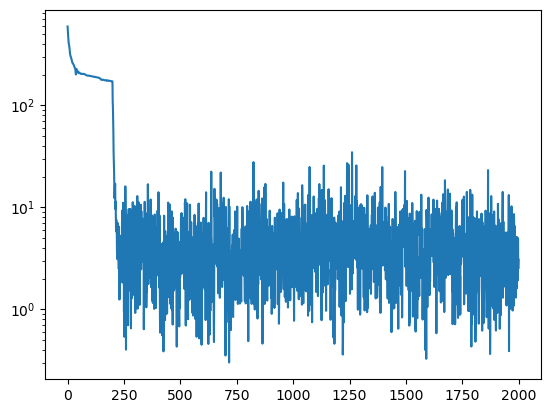

In [9]:
fig, ax = plt.subplots(1,1)
ax.plot(loss_hist)
ax.set_yscale('log')

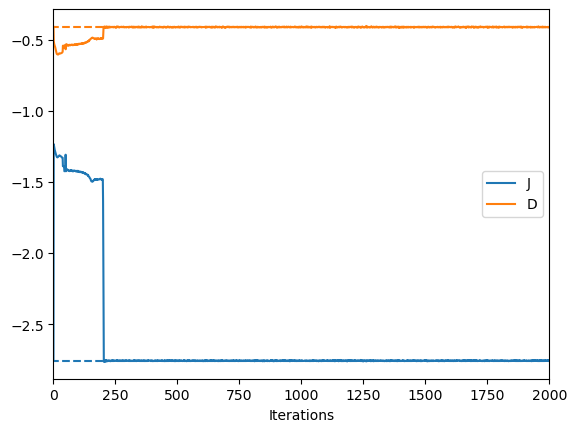

In [10]:
J_hist = torch.cat(model_spec.J_hist, dim=1)
J_hist_mean = J_hist.mean(axis=0)

D_hist = torch.cat(model_spec.D_hist, dim=1)
D_hist_mean = D_hist.mean(axis=0)

fig, ax = plt.subplots(1,1)
ax.plot(J_hist_mean, color='C0', label='J')
ax.plot(D_hist_mean, color='C1', label='D')
ax.hlines(x_val[0], -100, 1e4, color='C0', linestyle='--')
ax.hlines(x_val[1], -100, 1e4, color='C1', linestyle='--')
ax.set_xlim(0, len(loss_hist))
ax.set_xlabel("Iterations")
ax.legend()


In [11]:


batch_size = 10
# model_spec.J.data[:] = x_val[0]
# model_spec.D.data[:] = x_val[1]
# model_spec.K.data[:] = x_val[2]

x = torch.cat((model_spec.J, model_spec.D), dim=1)
y = model_spec.fc_net(x)
omega, inten = torch.split(y, [model_spec.num_mode, model_spec.num_mode], dim=1)
# batch x mode x time
S_envelope = torch.exp(-torch.einsum("bm,t->bmt", F.relu(model_spec.gamma), time_val))
S_pred = (batch_spec_to_Sqt(omega, inten, time_val) * S_envelope).sum(dim=1)
S_pred = S_pred / S_pred[:,0,None] * S_val[0]

loss_batch = (S_pred - torch.atleast_2d(S_val).repeat_interleave(batch_size,dim=0).to(S_pred)).pow(2).mean(dim=1)
print(loss_batch)
loss = F.mse_loss(S_pred, torch.atleast_2d(S_val).repeat_interleave(batch_size,dim=0).to(S_pred))

tensor([0.1890, 6.3416, 0.1890, 0.1890, 0.1890, 0.1890, 0.1890, 0.1890, 5.6064,
        0.1890], grad_fn=<MeanBackward1>)


In [12]:
print(x_val, y_val)

tensor([-2.7588, -0.4105]) tensor([10.2492, 16.8845,  5.7185,  3.2815])


In [13]:
print(model_spec.J, '\n', model_spec.D)

Parameter containing:
tensor([[-2.7571],
        [-2.7542],
        [-2.7571],
        [-2.7571],
        [-2.7571],
        [-2.7571],
        [-2.7571],
        [-2.7571],
        [-2.7516],
        [-2.7571]], requires_grad=True) 
 Parameter containing:
tensor([[-0.4113],
        [-0.4042],
        [-0.4113],
        [-0.4113],
        [-0.4113],
        [-0.4113],
        [-0.4113],
        [-0.4113],
        [-0.4043],
        [-0.4113]], requires_grad=True)


/tmp/ipykernel_53255/3111477490.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484806139/work/aten/src/ATen/native/TensorShape.cpp:2981.)
  plt.plot(time_val, S_val.detach().cpu().T)


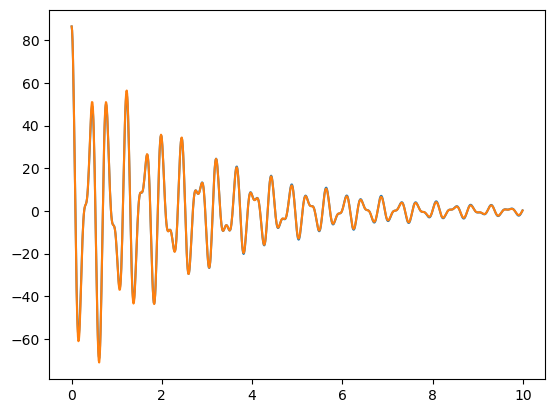

In [14]:
plt.plot(time_val, S_pred.detach().cpu().T[:,4])
plt.plot(time_val, S_val.detach().cpu().T)

In [18]:
import optbayesexpt as obe
from src.utils_model import spec_to_Sqt
import numpy as np
import torch.nn.functional as F
from scipy.interpolate import interp1d

In [85]:
# Describe how the world works with a model function
#
def array2tensor(arr):
    if isinstance(arr, np.ndarray):
        tensor = torch.from_numpy(arr)
        return tensor
    elif isinstance(arr, torch.Tensor):
        return arr
    else:
        raise ValueError("Input should be either numpy array or torch tensor.")
        
def tensor2array(tensor):
    if isinstance(tensor, torch.Tensor):
        arr = tensor.detach().cpu().numpy()
        return arr
    elif isinstance(tensor, np.ndarray):
        return tensor
    else:
        raise ValueError("Input should be either numpy array or torch tensor.")


def model_function(sets, pars, cons):
    """ Evaluates a trusted model of the experiment's output
    The equivalent of a fit function. The argument structure is
    required by OptBayesExpt.
    Args:
        sets: A tuple of setting values, or a tuple of settings arrays
        pars: A tuple of parameter arrays or a tuple of parameter values
        cons: A tuple of floats
    Returns:  the evaluated function
    """
    # unpack the settings
    # t, = sets
    # unpack model parameters
    t, = sets
    J, D, gamma = pars
    if isinstance(t, (int, float)):
        t = torch.tensor([t,])
    else:
        t = torch.atleast_1d(array2tensor(t))
    if isinstance(gamma, (int, float)):
        gamma = torch.atleast_2d(torch.tensor([gamma]))
    else:
        gamma = array2tensor(gamma)[:,None]

    if isinstance(J, (int, float)):
        J = torch.tensor([[J]])
        D = torch.tensor([[D]])
    else:
        J = array2tensor(J)[:,None]
        D = array2tensor(D)[:,None]

    x = torch.cat((J, D), dim=1)
    y = model_spec(x).cpu()

    omega, inten = torch.split(y, (y.shape[1]//2, y.shape[1]//2), dim=1)
    S_envelope = torch.exp(-torch.einsum("bm,t->bmt", F.relu(gamma), t))
    S_pred = (batch_spec_to_Sqt(omega, inten, t) * S_envelope).sum(dim=1)
    # calculate the Lorentzian
    return S_pred.detach().cpu().squeeze().numpy()

In [20]:
sets = (1.0, )
pars = (1.5, 0.5, 0.5)
cons = ()

In [21]:
model_function(sets, pars, cons)

array(10.56234732)

In [67]:
times = np.arange(0,10,0.01)
settings = (times, )
parameters = (
    np.random.uniform(-2.5,-1.5, 1001),
    np.random.uniform(-1.0,-0.0, 1001),
    np.random.uniform( 0.0, 1.0, 1001)
    )
constants = ()
obe_model = obe.OptBayesExpt(model_function, settings, parameters, constants)

noise_level = 1

In [98]:
x_val

tensor([-2.6193, -0.2535])

In [99]:
idx = np.random.choice(len(X_val))
# idx = 160
x_val = X_val[idx]
y_val = Y_val[idx]

omega_val, inten_val = [], []
for i in range(2):
    _omega, _inten = lorentzian(y_val[i], 0.25, y_val[i+2], minimum=0.)
    omega_val.append(_omega); inten_val.append(_inten)
omega_val = torch.cat(omega_val); inten_val = torch.cat(inten_val)

true_pars = x_val.cpu().numpy().tolist() + [0.25,]

time_val = torch.arange(0,10,0.01)
true_S = batch_spec_to_Sqt(omega_val, inten_val, time_val).sum(dim=1).squeeze()
true_S = model_function((time_val,), true_pars, ())

print(x_val, y_val)
print(model_spec(x_val))

func_S = interp1d(time_val, true_S)

def model_function_true(sets, pars, cons):
    """ Evaluates a trusted model of the experiment's output
    The equivalent of a fit function. The argument structure is
    required by OptBayesExpt.
    Args:
        sets: A tuple of setting values, or a tuple of settings arrays
        pars: A tuple of parameter arrays or a tuple of parameter values
        cons: A tuple of floats
    Returns:  the evaluated function
    """
    # unpack the settings
    # t, = sets
    # unpack model parameters
    t, = sets
    if isinstance(t, (int, float)):
        t = np.array([t,])
    else:
        t = np.atleast_1d(tensor2array(t))
        
    S_pred = func_S(t)
    # calculate the Lorentzian
    return S_pred

# obe_sim = obe.MeasurementSimulator(
#     model_function_true, (), (), noise_level=noise_level)
obe_sim = obe.MeasurementSimulator(
    model_function, true_pars, (), noise_level=noise_level)

tensor([-2.0774, -0.2814]) tensor([ 8.1438, 12.8563,  6.2085,  2.7915])
tensor([ 8.2122, 12.8178,  6.1969,  2.8956], grad_fn=<SqueezeBackward3>)


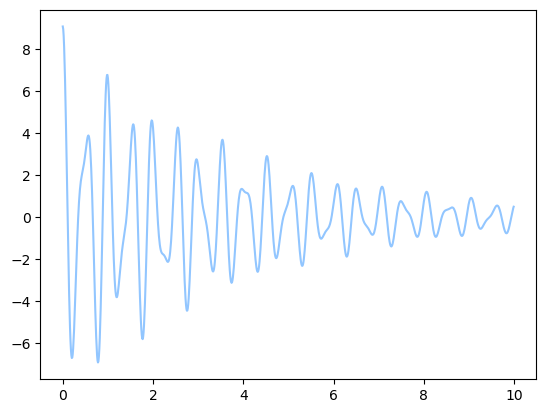

In [100]:
plt.plot(time_val, true_S)

In [101]:
next_t_lst = []
next_S_lst = []

param_mean = []
param_std  = []

num_sample_periter = 10
est_S_lst = []

maxiter = 200
for i in range(maxiter):
    next_t = obe_model.opt_setting()
    next_S = obe_sim.simdata(next_t, noise_level=noise_level)
    # next_S = func_S(next_t) + np.random.randn() * noise_level
    # print(next_t, next_S)

    measurement = (next_t, next_S, noise_level)
    obe_model.pdf_update(measurement)

    next_t_lst.append(next_t[0])
    next_S_lst.append(next_S)
    param_mean.append(obe_model.mean())
    param_std.append(obe_model.std())
    pars = [np.random.normal(obe_model.mean()[i], obe_model.std()[i], num_sample_periter) for i in range(len(obe_model.mean()))]
    est_S_lst.append(
        model_function(
            (times,), pars, ()
        )
    )

    if np.all(param_std[-1] < 1e-5):
        break

next_t_lst = np.asarray(next_t_lst)
next_S_lst = np.asarray(next_S_lst)
param_mean = np.asarray(param_mean)
param_std = np.asarray(param_std)
est_S_lst = np.asarray(est_S_lst)

maxiter = len(param_mean)

C:\Users\zhantao\AppData\Local\Temp\ipykernel_23044\891140015.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-pastel')


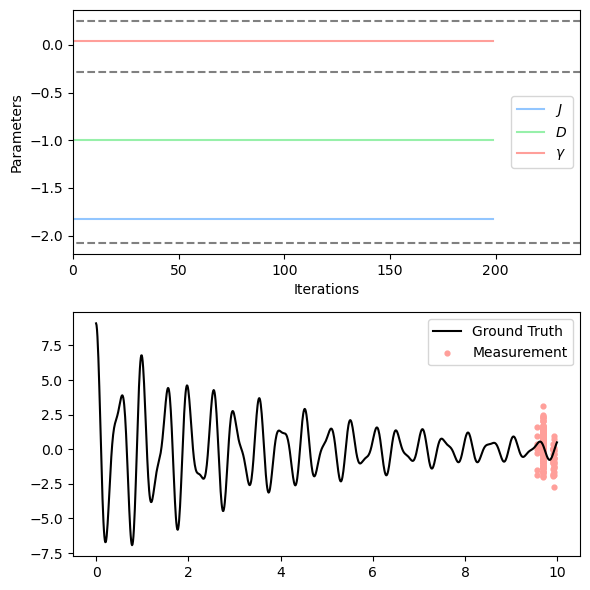

In [102]:
label_lst = ["$J$", "$D$", "$\gamma$"]

plt.style.use('seaborn-pastel')
fig, ax = plt.subplots(2,1,figsize=(6,6))
ax[0].plot(np.arange(maxiter), param_mean)
for i in range(param_mean.shape[1]):
    ax[0].fill_between(np.arange(maxiter), param_mean[:,i]-param_std[:,i], param_mean[:,i]+param_std[:,i], alpha=0.2)
    ax[0].hlines(true_pars[i], -100, 100*maxiter, linestyles='--', color='gray')
ax[0].set_xlim([-0.*maxiter, 1.2*maxiter])
ax[0].legend(label_lst, loc='center right')
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Parameters")

ax[1].plot(times, true_S, color='k', label="Ground Truth")
ax[1].scatter(next_t_lst, next_S_lst, label="Measurement", s=12, color='C2')
ax[1].legend()

fig.tight_layout()

In [25]:
from matplotlib.animation import FuncAnimation

# plt.style.use('seaborn-pastel')
# fig, ax = plt.subplots(2,1,figsize=(6,6))

fig = plt.Figure(figsize=(6,6)) # this creates a Figure() instance
# ax = fig.add_subplot()
gs = fig.add_gridspec(2,1)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

ax0.set_xlim([-0.*maxiter, 1.2*maxiter])
ax0.set_ylim([-2.5,1.0])
ax0.set_xlabel("Iterations")
ax0.set_ylabel("Parameters")
for i in range(param_mean.shape[1]):
    # ax[0].fill_between(np.arange(maxiter), param_mean[:,i]-param_std[:,i], param_mean[:,i]+param_std[:,i], alpha=0.2)
    ax0.hlines(true_pars[i], -100, 100*maxiter, linestyles='--', color='gray')

ax1.set_xlim([0, 1.1*times.max()])
ax1.plot(times, true_S, color='k', label="Ground Truth")
line_pred, = ax1.plot([], [], lw=2)
sc = ax1.scatter([], [], color='C2', s=12)

line_J, = ax0.plot([], [], lw=2)
line_D, = ax0.plot([], [], lw=2)
line_gamma, = ax0.plot([], [], lw=2)

def init():
    i=1
    line_J.set_data(np.arange(i), param_mean[:i,0])
    line_D.set_data(np.arange(i), param_mean[:i,1])
    line_gamma.set_data(np.arange(i), param_mean[:i,2])
    line_J.set_label(label_lst[0])
    line_D.set_label(label_lst[1])
    line_gamma.set_label(label_lst[2])
    ax0.legend(loc='center right')
    sc.set_offsets(np.concatenate((next_t_lst[:i,None], next_S_lst[:i,None]),axis=1))
    line_pred.set_data(times, est_S_lst.mean(axis=1)[i])
    sc.set_zorder(10)
    return line_J, line_D, line_gamma, sc, line_pred
def animate(i):
    line_J.set_data(np.arange(i), param_mean[:i,0])
    line_D.set_data(np.arange(i), param_mean[:i,1])
    line_gamma.set_data(np.arange(i), param_mean[:i,2])
    sc.set_offsets(np.concatenate((next_t_lst[:i,None], next_S_lst[:i,None]),axis=1))
    line_pred.set_data(times, est_S_lst.mean(axis=1)[i])
    sc.set_zorder(10)
    return line_J, line_D, line_gamma, sc, line_pred

anim = FuncAnimation(
    fig, animate, init_func=init,
    frames=maxiter, interval=250, blit=True)

anim.save(
    f'out/gifs/sequential_J={true_pars[0]}_D={true_pars[1]}_gamma={true_pars[2]}.gif', 
    dpi=300)

/tmp/ipykernel_53255/1286530858.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-pastel')


In [24]:
# anim.save(f'out/gifs/sequential_J={true_pars[0]}_D={true_pars[1]}_gamma={true_pars[2]}.gif', dpi=300)

C:\Users\zhantao\AppData\Local\Temp\ipykernel_19272\1560978546.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-pastel')


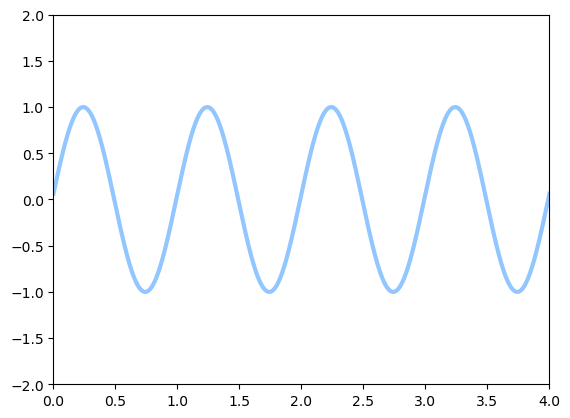

In [206]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
plt.style.use('seaborn-pastel')


fig = plt.figure()
ax = plt.axes(xlim=(0, 4), ylim=(-2, 2))
line, = ax.plot([], [], lw=3)

def init():
    line.set_data([], [])
    return line,
def animate(i):
    x = np.linspace(0, 4, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

anim = FuncAnimation(
    fig, animate, init_func=init,
    frames=200, interval=20, blit=True)


anim.save('sine_wave.gif', writer='imagemagick')